# Solutions

## About the data
These exercises use the [`stock_analysis`](https://github.com/stefmolin/stock-analysis) package for collection of financial data.

## Setup

In [1]:
%matplotlib inline
import stock_analysis
from stock_analysis.utils import group_stocks

reader = stock_analysis.StockReader('2017-01-01', '2018-12-31')

# get bitcoin data
bitcoin = reader.get_bitcoin_data('USD')

# get faang data
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker)
    for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

# get S&P 500 data
sp = reader.get_index_data('S&P 500')

faang = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

## Exercise 1
Using the `StockAnalyzer` and `StockVisualizer` classes, calculate and plot three levels of support and resistance for Netflix's closing price from 2017-2018.

Text(0, 0.5, 'price ($)')

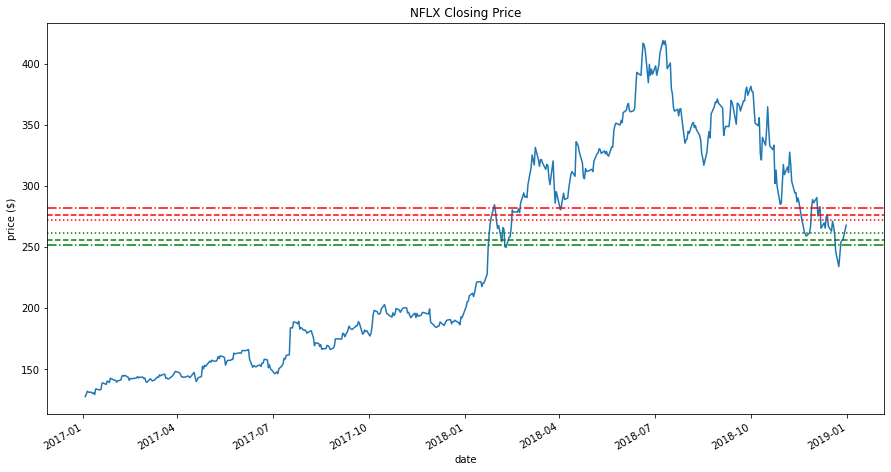

In [2]:
import itertools

def levels(analyzer, method):
    return [getattr(analyzer, method)(i) for i in range(1, 4)]

# calculate support/resistance levels
nflx_analyzer = stock_analysis.StockAnalyzer(nflx)
support_levels, resistance_levels = (
    levels(nflx_analyzer, metric) for metric in ['support', 'resistance']
)

nflx_viz = stock_analysis.StockVisualizer(nflx)
ax = nflx_viz.evolution_over_time('close', figsize=(15, 8), title='NFLX Closing Price')

for support, resistance, linestyle, level in zip(
    support_levels, resistance_levels, 
    [':', '--', '-.'], itertools.count(1)
):
    nflx_viz.add_reference_line(
        ax, 
        y=support, 
        label=f'support level {level}', 
        color='green', 
        linestyle=linestyle
    )
    nflx_viz.add_reference_line(
        ax, 
        y=resistance, 
        label=f'resistance level {level}', 
        color='red', 
        linestyle=linestyle
    )
ax.get_legend().remove()
ax.set_ylabel('price ($)')

## Exercise 2
With the `StockVisualizer` class, look at the effect of after-hours trading on the FAANG stocks.
1. As individual stocks
2. As the group using the sum of their closing and opening prices

### Part 1

array([[<AxesSubplot:title={'center':"Amazon Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Amazon after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Apple Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Apple after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Facebook Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Facebook after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Google Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Google after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Netflix Open Price - Prior Day's Close"}, xlabel='da

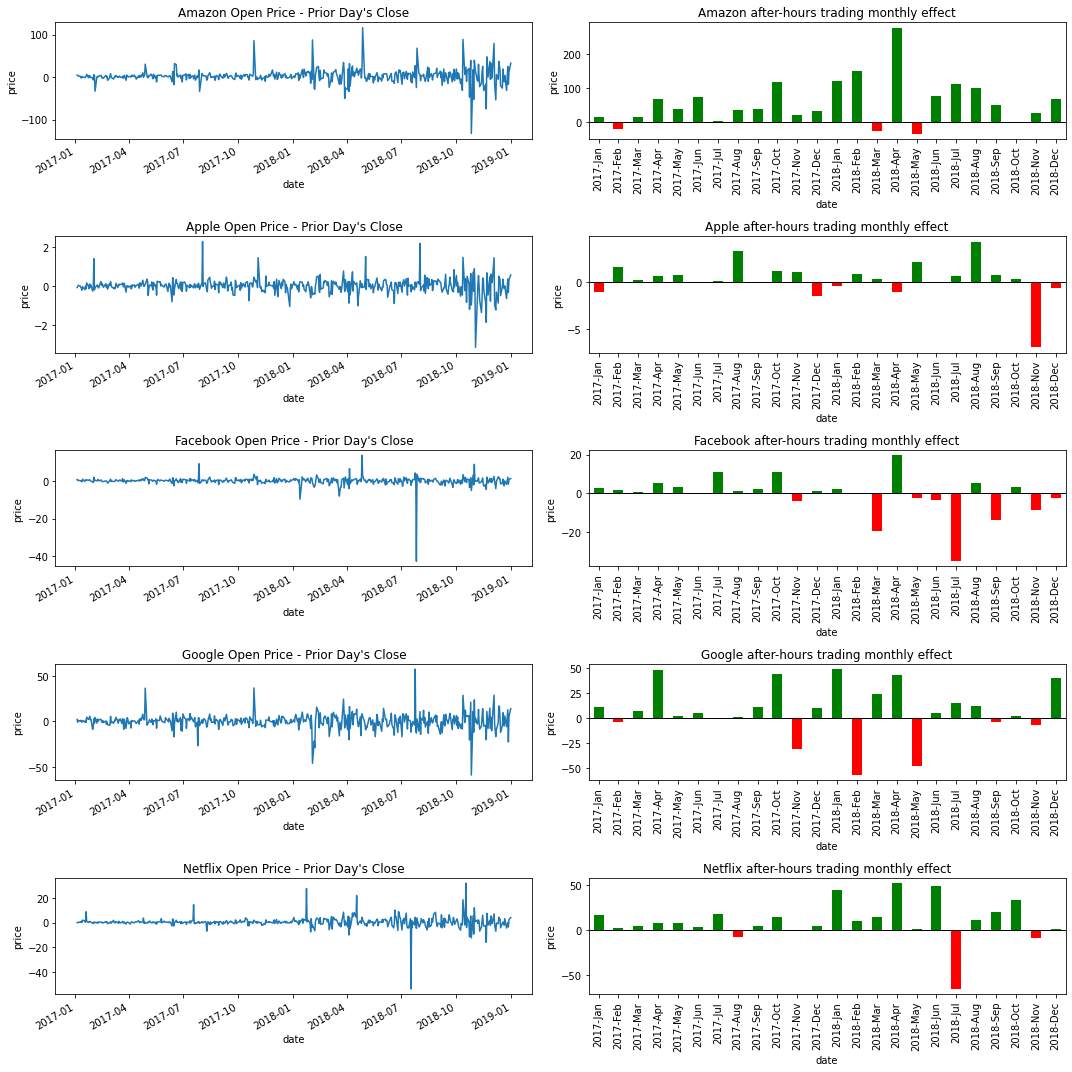

In [3]:
stock_analysis.AssetGroupVisualizer(faang).after_hours_trades()

### Part 2

array([<AxesSubplot:title={'center':"After-hours trading\n(Open Price - Prior Day's Close)"}, xlabel='date', ylabel='price'>,
       <AxesSubplot:title={'center':'After-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
      dtype=object)

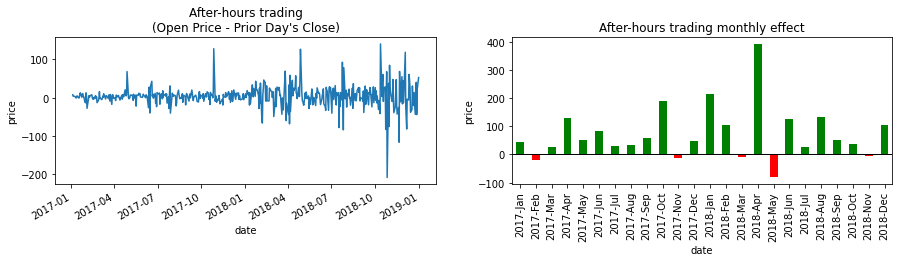

In [4]:
from stock_analysis.utils import make_portfolio

stock_analysis.StockVisualizer(make_portfolio(faang)).after_hours_trades()

## Exercise 3
### FAANG Portfolio
Using the `StockVisualizer.open_to_close()` method, create a plot that fills the area between the FAANG portfolio's opening price and its closing price each day in red if the price declined and in green if the price increased.

Text(0, 0.5, 'price')

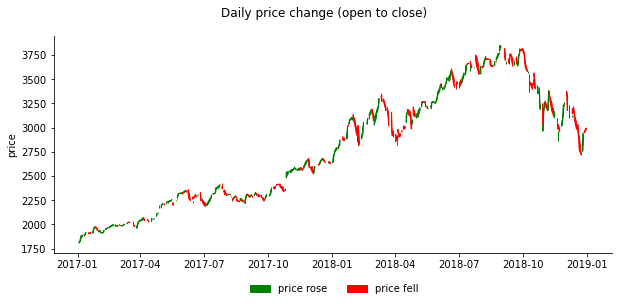

In [5]:
from stock_analysis.utils import make_portfolio
stock_analysis.StockVisualizer(make_portfolio(faang)).open_to_close()

### Bonus: Portfolio of S&P 500 and Bitcoin
Note that after reindexing the S&P 500 data, we can simply add it with the bitcoin data to get the portfolio value:

Text(0, 0.5, 'price')

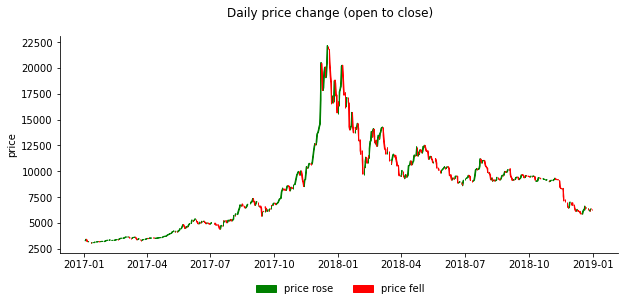

In [6]:
import pandas as pd
import numpy as np

def reindex_stock_data(df):
    """Handles reindexing of stock data"""
    result = df.copy().reindex(
        pd.date_range('2017-01-01', end='2018-12-31', freq='D')
    ).assign(
        volume=lambda x: x.fillna(0),
        close=lambda x: x.fillna(method='ffill'),
        open=lambda x: x.open.combine_first(x.close),
        high=lambda x: x.high.combine_first(x.close),
        low=lambda x: x.low.combine_first(x.close)
    )
    result.index.rename('date', inplace=True)
    return result

sp_reindexed = reindex_stock_data(sp)

stock_analysis.StockVisualizer(bitcoin + sp_reindexed).open_to_close()

## Exercise 4
Compare a mutual fund or ETF (Exchange Traded Fund) of your choice to 3 of its largest assets (by composition), using annualized volatility and the `AssetGroupAnalyzer` class. These funds are built to mitigate risk, so volatility for the fund will be lower than that of the assets that compose it.

*Note: Solution uses the mutual fund FBALX, whose composition can be found at https://fundresearch.fidelity.com/mutual-funds/composition/316345206. Composition used for the solution taken on April 14, 2019.*

In [7]:
fbalx = reader.get_ticker_data('FBALX')
msft = reader.get_ticker_data('MSFT')
mutual_fund = group_stocks({
    '0 - FBALX': fbalx,
    '1 - Microsoft': msft,
    '2 - Apple': aapl,
    '3 - Amazon': amzn
})
stock_analysis.AssetGroupAnalyzer(mutual_fund).analyze('annualized_volatility')

{'0 - FBALX': 0.13084907578280824,
 '1 - Microsoft': 0.2823678701754217,
 '2 - Apple': 0.28709412666171025,
 '3 - Amazon': 0.3606494363818415}

## Exercise 5
Write a function that returns a dataframe of one row with columns `alpha`, `beta`, `annualized_volatility`, `is_bear_market`, and `is_bull_market` which each contain the results of running the respective methods on a given stock using the `StockAnalyzer` class. Here, we are using a risk-free rate of return of 2.69% (government treasury bond rate as of 12/31/18). You can look up rates [here](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=yield).

In [8]:
import pandas as pd

def metric_table(stock, index):
    """
    Make a table of metrics for a stock.

    Parameters:
        - stock: The stock's dataframe.
        - index: The dataframe for the index.
     
    Returns:
        A `pandas.DataFrame` object with a single row of metrics
    """
    return pd.DataFrame({
        metric: getattr(
            stock_analysis.StockAnalyzer(stock), 
            metric
        )(**kwargs) \
        for metric, kwargs in {
            'alpha': {'index': index, 'r_f': 2.69}, 
            'beta': {'index': index}, 
            'annualized_volatility': {},
            'is_bear_market': {},
            'is_bull_market': {}
        }.items()
    }, index=range(1))

metric_table(fbalx, sp)

,alpha,beta,annualized_volatility,is_bear_market,is_bull_market
0,-0.148175,0.632124,0.130849,False,False
